In [1]:
#packages
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning
import s3fs

In [2]:
# Filter out multiple warning categories
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('mode.chained_assignment', None)

In [3]:
# Define your S3 bucket and folder

# Define the full S3 path to the file
s3_file_path = 's3://keepaustinweird/austin_key/data.csv'

# Read the file into a Pandas DataFrame
filtered_df = pd.read_csv(s3_file_path)

# Display the DataFrame
filtered_df.head()


,published_date,issue_reported,latitude,longitude,address,traffic_report_status,traffic_report_status_date_time
0,2024-01-24 23:32:05+00:00,Stalled Vehicle,0.000000,0.000000,200 Dedman,ARCHIVED,2024-01-25T00:15:11.000Z
1,2024-01-01 04:39:24+00:00,VEHICLE FIRE,30.376018,-97.501944,14614 BOIS D ARC RD,ARCHIVED,2024-01-01T05:10:08.000Z
2,2024-01-01 07:05:26+00:00,Crash Service,30.302704,-97.661269,Loyola Ln / Ed Bluestein Blvd Svrd Sb,ARCHIVED,2024-01-01T10:30:07.000Z
3,2024-01-01 10:53:42+00:00,Crash Service,30.385992,-97.672917,11900 N IH 35 NB,ARCHIVED,2024-01-01T18:00:09.000Z
4,2024-01-01 05:01:41+00:00,COLLISION,30.344979,-97.580056,10212-10256 E US 290 HWY SVRD WB,ARCHIVED,2024-01-01T06:15:08.000Z


In [4]:
#MAPPING AUSTIN

#drop longitude and latitude where it is 0,0 and drop na values
value_to_drop = 0
filtered_df2 = filtered_df[(filtered_df['longitude'] != value_to_drop) & (filtered_df["latitude"] != value_to_drop)]
filtered_df2 = filtered_df2.dropna()

#creating a new df with just longitude, latitude, and incident type
mapping_df = filtered_df2[["issue_reported", "latitude", "longitude"]]
mapping_df.head()

,issue_reported,latitude,longitude
1,VEHICLE FIRE,30.376018,-97.501944
2,Crash Service,30.302704,-97.661269
3,Crash Service,30.385992,-97.672917
4,COLLISION,30.344979,-97.580056
5,Crash Urgent,30.356958,-97.679610


In [5]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Calculate the differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance
    distance = R * c

    return distance

# Example usage with the coordinates you provided (30.271, -97.743)
target_coordinates = (30.271, -97.743)
# other_coordinates = (your_other_latitude, your_other_longitude)  # Replace with your own coordinates

# distance = haversine_distance(target_coordinates[0], target_coordinates[1],
#                               other_coordinates[0], other_coordinates[1])

# print(f"The distance between the coordinates is {distance:.2f} kilometers.")


In [6]:
# Function to calculate distances and create a new column in the DataFrame
def calculate_distances(row):
    target_coordinates = (30.271, -97.743)
    return haversine_distance(target_coordinates[0], target_coordinates[1], row['latitude'], row['longitude'])

# Apply the function to each row and create a new 'Distance' column
mapping_df['Distance_from_dt'] = mapping_df.apply(calculate_distances, axis=1)

# Display the updated DataFrame
print(mapping_df)


       issue_reported   latitude  longitude  Distance_from_dt
1        VEHICLE FIRE  30.376018 -97.501944         25.916930
2       Crash Service  30.302704 -97.661269          8.603114
3       Crash Service  30.385992 -97.672917         14.447816
4           COLLISION  30.344979 -97.580056         17.673335
5        Crash Urgent  30.356958 -97.679610         11.330630
...               ...        ...        ...               ...
9150     Crash Urgent  30.430128 -97.669529         19.046981
9151     Crash Urgent  30.357394 -97.686549         11.029493
9152     Crash Urgent  30.410006 -97.711057         15.757802
9153        COLLISION  30.282229 -97.623206         11.571153
9154  Stalled Vehicle  30.310519 -97.709332          5.455248

[9121 rows x 4 columns]


In [7]:
def classify_location(distance):
    if distance < 1.5:
        return 'Downtown'
    else:
        return 'Not Downtown'

# Function to calculate distances and create a new column in the DataFrame
def calculate_distances(row):
    target_coordinates = (30.271, -97.743)
    return haversine_distance(target_coordinates[0], target_coordinates[1], row['latitude'], row['longitude'])

# Apply the function to each row and create a new 'Distance' column
mapping_df['Distance'] = mapping_df.apply(calculate_distances, axis=1)

# Create a new column 'Location_Class' based on the distances
mapping_df['Location_Class'] = mapping_df['Distance'].apply(classify_location)

In [8]:
mapping_df.Location_Class.value_counts()

Location_Class
Not Downtown    8676
Downtown         445
Name: count, dtype: int64

In [9]:
# Function to calculate distances and create a new column in the DataFrame
def calculate_distances_UT(row):
    target_coordinates = (30.285, -97.7335)
    return haversine_distance(target_coordinates[0], target_coordinates[1], row['latitude'], row['longitude'])

# Apply the function to each row and create a new 'Distance' column
mapping_df['Distance_from_UT'] = mapping_df.apply(calculate_distances_UT, axis=1)

# Display the updated DataFrame
print(mapping_df)

       issue_reported   latitude  longitude  Distance_from_dt   Distance  \
1        VEHICLE FIRE  30.376018 -97.501944         25.916930  25.916930   
2       Crash Service  30.302704 -97.661269          8.603114   8.603114   
3       Crash Service  30.385992 -97.672917         14.447816  14.447816   
4           COLLISION  30.344979 -97.580056         17.673335  17.673335   
5        Crash Urgent  30.356958 -97.679610         11.330630  11.330630   
...               ...        ...        ...               ...        ...   
9150     Crash Urgent  30.430128 -97.669529         19.046981  19.046981   
9151     Crash Urgent  30.357394 -97.686549         11.029493  11.029493   
9152     Crash Urgent  30.410006 -97.711057         15.757802  15.757802   
9153        COLLISION  30.282229 -97.623206         11.571153  11.571153   
9154  Stalled Vehicle  30.310519 -97.709332          5.455248   5.455248   

     Location_Class  Distance_from_UT  
1      Not Downtown         24.419666  
2      

In [10]:
mapping_df.head()

,issue_reported,latitude,longitude,Distance_from_dt,Distance,Location_Class,Distance_from_UT
1,VEHICLE FIRE,30.376018,-97.501944,25.916930,25.916930,Not Downtown,24.419666
2,Crash Service,30.302704,-97.661269,8.603114,8.603114,Not Downtown,7.208981
3,Crash Service,30.385992,-97.672917,14.447816,14.447816,Not Downtown,12.645671
4,COLLISION,30.344979,-97.580056,17.673335,17.673335,Not Downtown,16.168758
5,Crash Urgent,30.356958,-97.679610,11.330630,11.330630,Not Downtown,9.527736


In [11]:
# Function to classify points as "Close to Campus" or "not"
def classify_location_UT(distance):
    if distance < 2.0:
        return 'Close to UT Austin'
    else:
        return 'Not Close'

# Apply the function to each row and create a new 'Distance' column
mapping_df['Distance_UT'] = mapping_df.apply(calculate_distances_UT, axis=1)

# Create a new column 'Location_Class' based on the distances
mapping_df['Location_Class_UT'] = mapping_df['Distance_UT'].apply(classify_location_UT)


In [12]:
mapping_df

,issue_reported,latitude,longitude,Distance_from_dt,Distance,Location_Class,Distance_from_UT,Distance_UT,Location_Class_UT
1,VEHICLE FIRE,30.376018,-97.501944,25.916930,25.916930,Not Downtown,24.419666,24.419666,Not Close
2,Crash Service,30.302704,-97.661269,8.603114,8.603114,Not Downtown,7.208981,7.208981,Not Close
3,Crash Service,30.385992,-97.672917,14.447816,14.447816,Not Downtown,12.645671,12.645671,Not Close
4,COLLISION,30.344979,-97.580056,17.673335,17.673335,Not Downtown,16.168758,16.168758,Not Close
5,Crash Urgent,30.356958,-97.679610,11.330630,11.330630,Not Downtown,9.527736,9.527736,Not Close
...,...,...,...,...,...,...,...,...,...
9150,Crash Urgent,30.430128,-97.669529,19.046981,19.046981,Not Downtown,17.265373,17.265373,Not Close
9151,Crash Urgent,30.357394,-97.686549,11.029493,11.029493,Not Downtown,9.225462,9.225462,Not Close
9152,Crash Urgent,30.410006,-97.711057,15.757802,15.757802,Not Downtown,14.065877,14.065877,Not Close
9153,COLLISION,30.282229,-97.623206,11.571153,11.571153,Not Downtown,10.595048,10.595048,Not Close


In [13]:
mapping_df.Location_Class_UT.value_counts()

Location_Class_UT
Not Close             8782
Close to UT Austin     339
Name: count, dtype: int64

In [14]:
# Filter the DataFrame based on conditions
filtered_data = mapping_df[(mapping_df['Location_Class'] == 'Downtown') & (mapping_df['Location_Class_UT'] == 'Close to UT Austin')]

# Count the number of observations
count_observations = len(filtered_data)

print(f"The number of observations that are both 'Downtown' and 'Close to Campus' is: {count_observations}")

The number of observations that are both 'Downtown' and 'Close to Campus' is: 184


In [15]:
import numpy as np

# Define your conditions and corresponding values
conditions = [
    (mapping_df['Location_Class'] == 'Downtown') & (mapping_df['Location_Class_UT'] == 'Not Close'),
    (mapping_df['Location_Class'] == 'Not Downtown') & (mapping_df['Location_Class_UT'] == 'Close to UT Austin'),
    (mapping_df['Location_Class'] == 'Downtown') & (mapping_df['Location_Class_UT'] == 'Close to UT Austin'),
    (mapping_df['Location_Class'] == 'Not Downtown') & (mapping_df['Location_Class_UT'] == 'Not Close')
]

values = [
    'Only Downtown',  # Value when Condition 1 is True
    'Only Close to Campus',  # Value when Condition 2 is True
    'Both', # Value when Condition 3 is True
    "Neither" 
    
]

# Create a new column based on the conditions
mapping_df['Location_Overlap'] = np.select(conditions, values)

In [16]:
mapping_df.head()

,issue_reported,latitude,longitude,Distance_from_dt,Distance,Location_Class,Distance_from_UT,Distance_UT,Location_Class_UT,Location_Overlap
1,VEHICLE FIRE,30.376018,-97.501944,25.916930,25.916930,Not Downtown,24.419666,24.419666,Not Close,Neither
2,Crash Service,30.302704,-97.661269,8.603114,8.603114,Not Downtown,7.208981,7.208981,Not Close,Neither
3,Crash Service,30.385992,-97.672917,14.447816,14.447816,Not Downtown,12.645671,12.645671,Not Close,Neither
4,COLLISION,30.344979,-97.580056,17.673335,17.673335,Not Downtown,16.168758,16.168758,Not Close,Neither
5,Crash Urgent,30.356958,-97.679610,11.330630,11.330630,Not Downtown,9.527736,9.527736,Not Close,Neither


In [31]:
mapping_df.groupby("Location_Overlap").size().reset_index(name="Count")

,Location_Overlap,Count
0,Both,184
1,Neither,8521
2,Only Close to Campus,155
3,Only Downtown,261


In [17]:
# Filter the DataFrame based on conditions
filtered_overlap_data = mapping_df[mapping_df['Location_Overlap'] != 'Neither']


In [18]:
filtered_overlap_data

,issue_reported,latitude,longitude,Distance_from_dt,Distance,Location_Class,Distance_from_UT,Distance_UT,Location_Class_UT,Location_Overlap
15,Crash Urgent,30.269211,-97.727084,1.541375,1.541375,Not Downtown,1.860625,1.860625,Close to UT Austin,Only Close to Campus
24,Traffic Hazard,30.289294,-97.723449,2.768125,2.768125,Not Downtown,1.076730,1.076730,Close to UT Austin,Only Close to Campus
30,Crash Service,30.267725,-97.734299,0.911508,0.911508,Downtown,1.922424,1.922424,Close to UT Austin,Both
33,Crash Urgent,30.296906,-97.718262,3.733672,3.733672,Not Downtown,1.973126,1.973126,Close to UT Austin,Only Close to Campus
40,Traffic Hazard,30.278546,-97.750713,1.119221,1.119221,Downtown,1.801921,1.801921,Close to UT Austin,Both
...,...,...,...,...,...,...,...,...,...,...
9131,Crash Service,30.261315,-97.737080,1.217788,1.217788,Downtown,2.655996,2.655996,Not Close,Only Downtown
9136,Traffic Hazard,30.260995,-97.735784,1.310701,1.310701,Downtown,2.678231,2.678231,Not Close,Only Downtown
9140,Traffic Hazard,30.270471,-97.740426,0.254093,0.254093,Downtown,1.747095,1.747095,Close to UT Austin,Both
9144,Crash Service,30.261120,-97.736159,1.280071,1.280071,Downtown,2.667584,2.667584,Not Close,Only Downtown


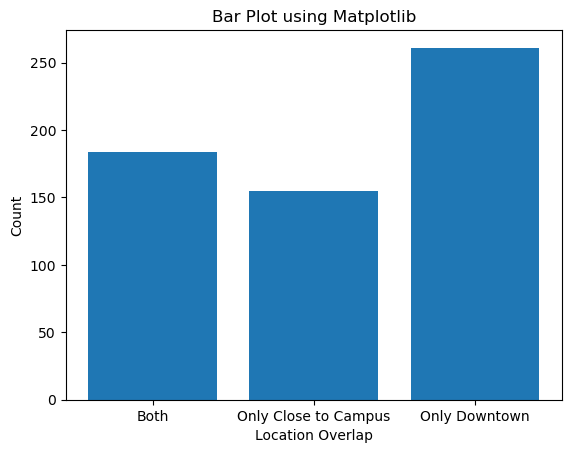

In [19]:
import matplotlib.pyplot as plt

counts = filtered_overlap_data.groupby("Location_Overlap").size().reset_index(name="Count")

# Create a bar plot
plt.bar(counts["Location_Overlap"], counts["Count"])
# Set plot labels and title
plt.xlabel("Location Overlap")
plt.ylabel("Count")
plt.title("Bar Plot using Matplotlib")

# Show the plot
plt.show()

In [20]:
counts

,Location_Overlap,Count
0,Both,184
1,Only Close to Campus,155
2,Only Downtown,261


In [21]:
!pip install plotnine

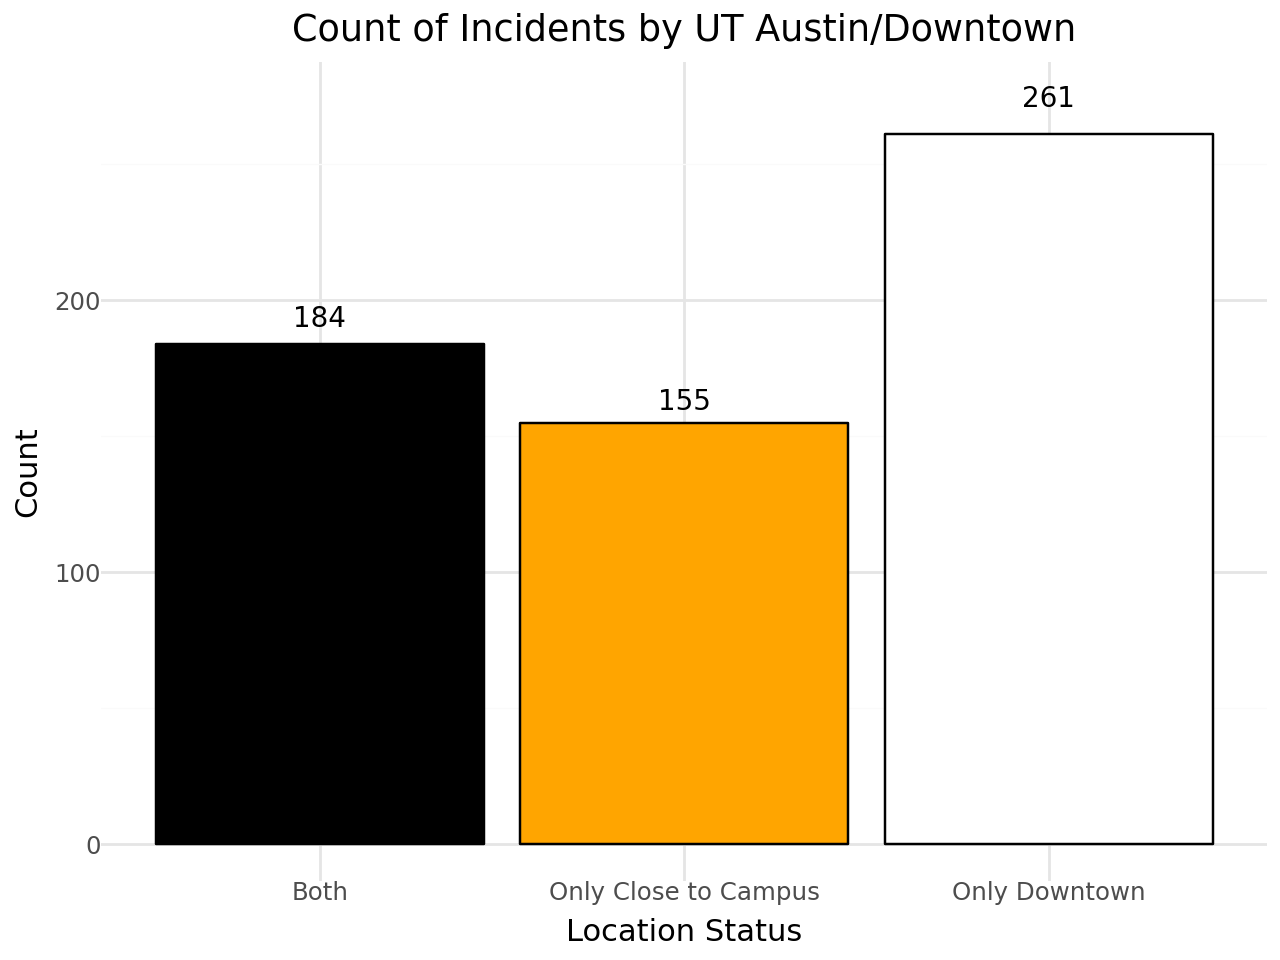

In [22]:
from plotnine import *

# Create a column chart
(ggplot(counts, aes(x="Location_Overlap", y="Count",fill="Location_Overlap",color="Location_Overlap")) +
 geom_col() +
 labs(title='Count of Incidents by UT Austin/Downtown', x='Location Status', y='Count') +
 scale_fill_manual(values=("black","orange","white")) +
 scale_color_manual(values=("black","black","black")) +
 theme_minimal()+
 geom_text(aes(label='Count'),            # Add text labels at the top of each column
                  position=position_stack(vjust=1.05),           # Adjust the vertical position of labels
                  size=10, color='black') +
 theme(legend_position='none')) # Removing Legend for Location

In [23]:
# Looking at Issues Reported within Each Location Status group
issue_overlap_df = filtered_overlap_data.groupby('issue_reported')['Location_Overlap'].value_counts().reset_index()
issue_overlap_df

,issue_reported,Location_Overlap,count
0,COLLISN/ LVNG SCN,Both,2
1,Crash Service,Only Downtown,46
2,Crash Service,Both,36
3,Crash Service,Only Close to Campus,22
4,Crash Urgent,Only Downtown,88
5,Crash Urgent,Both,75
6,Crash Urgent,Only Close to Campus,48
7,Stalled Vehicle,Both,9
8,Stalled Vehicle,Only Downtown,8
9,Stalled Vehicle,Only Close to Campus,4


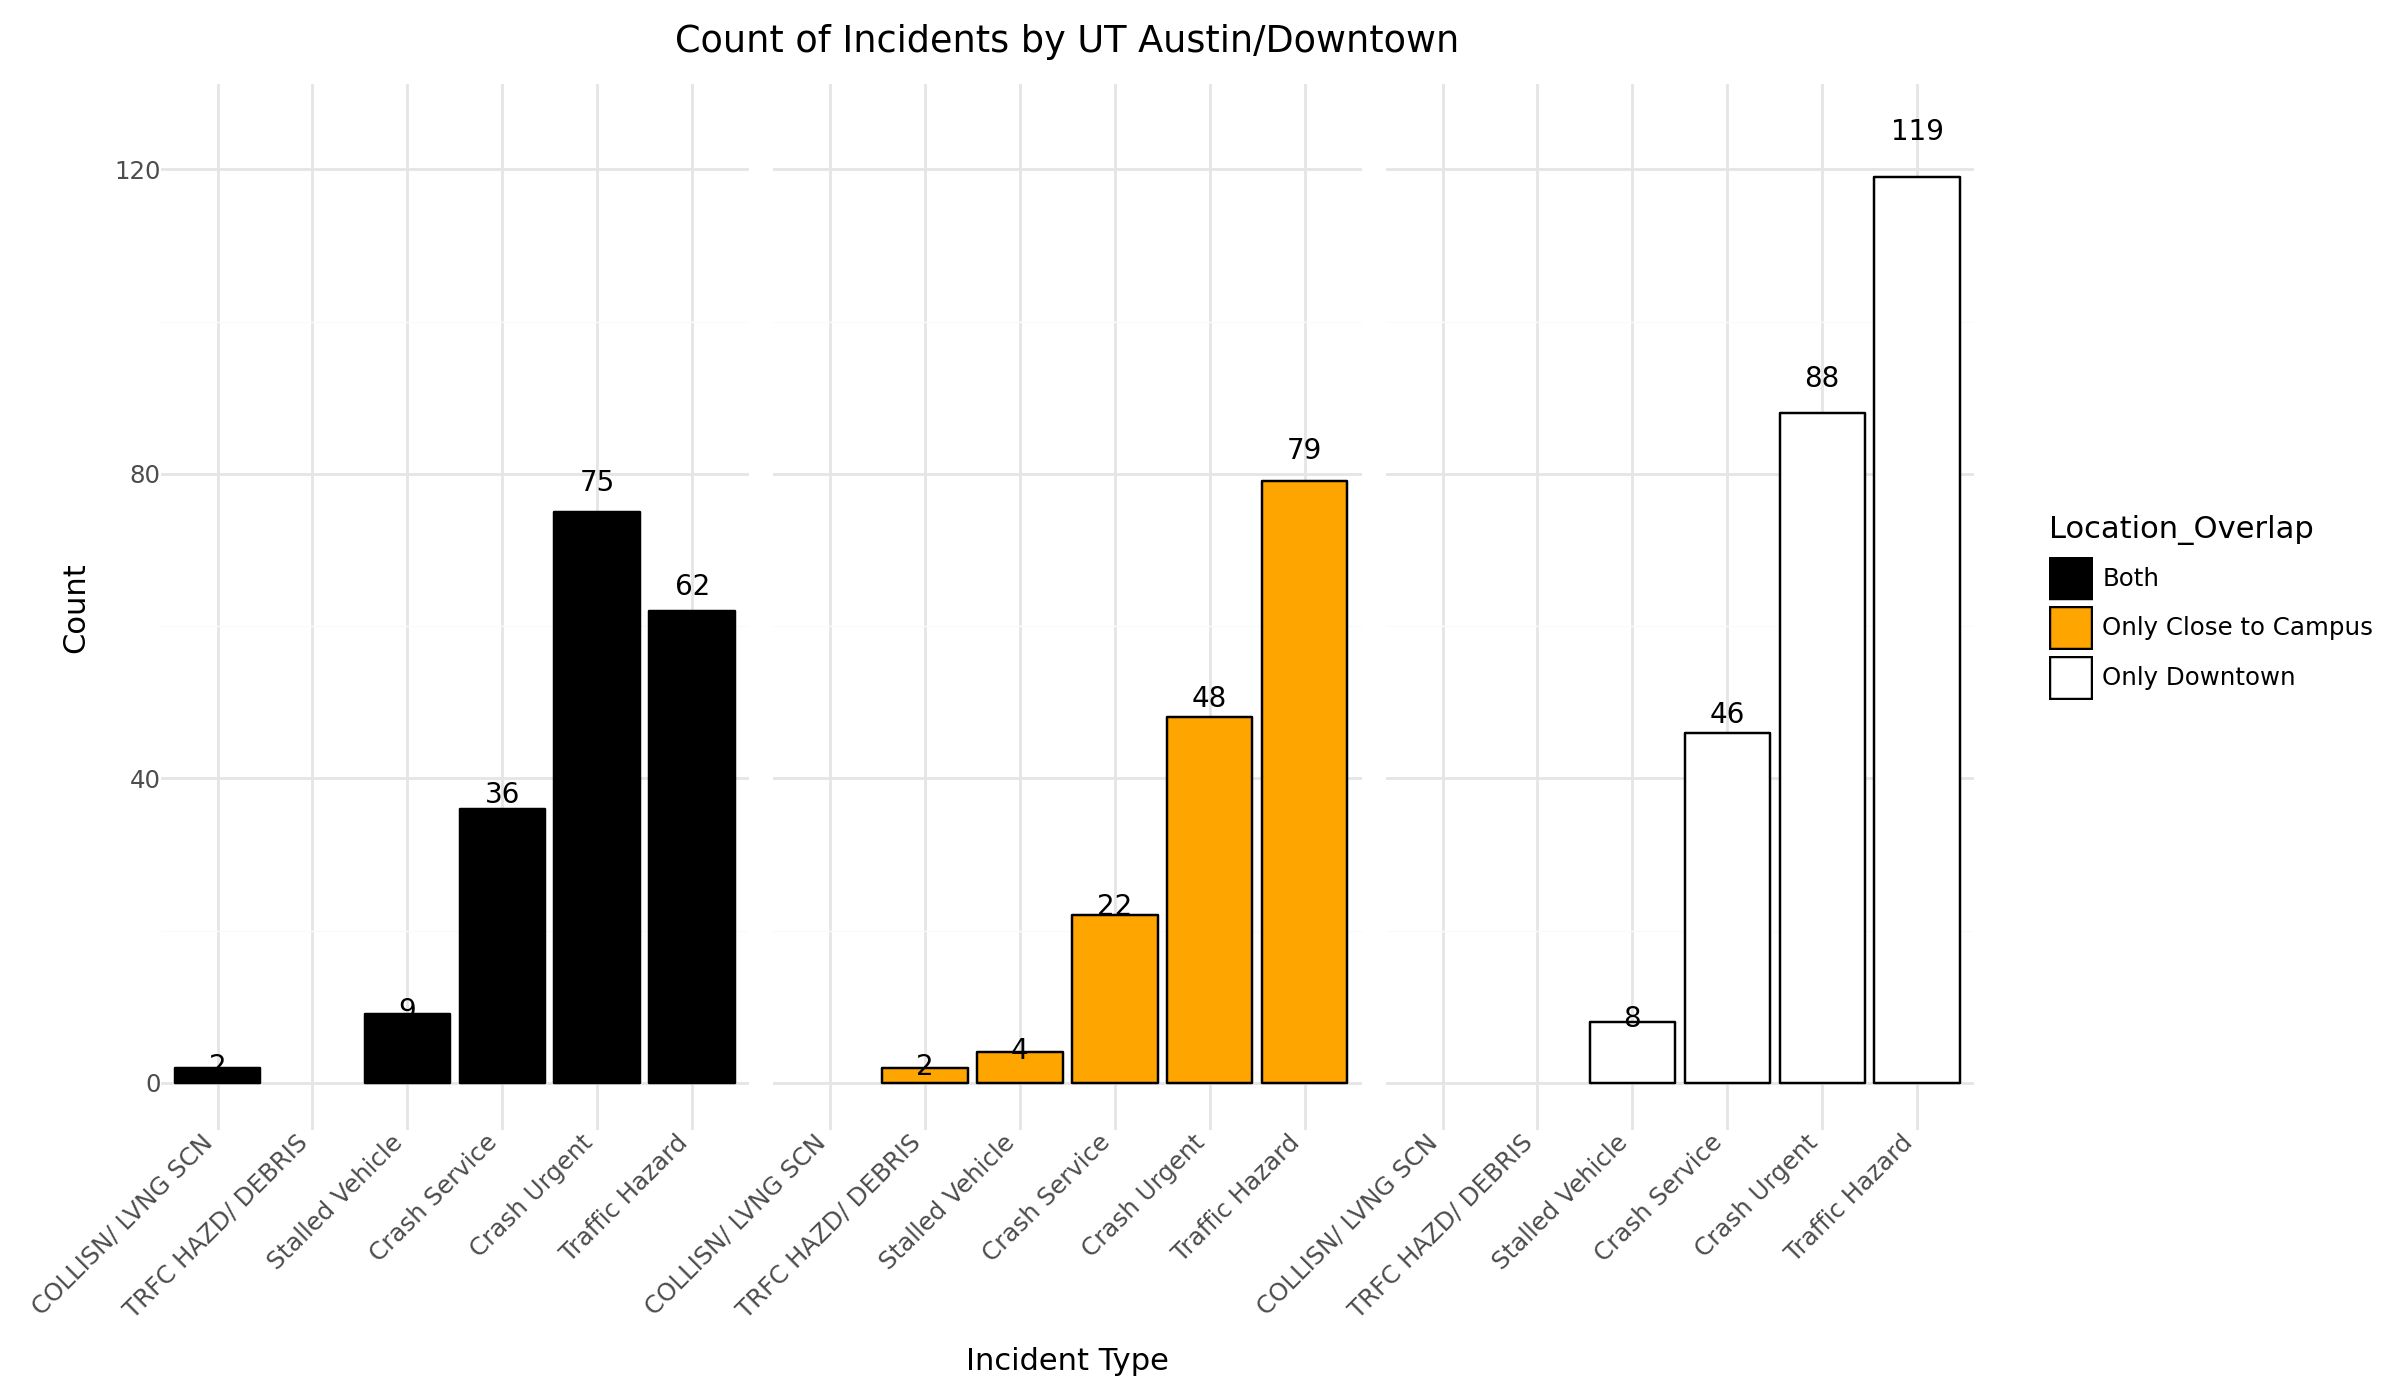

In [30]:
# Create a column chart

# Define a custom labelling function
def custom_labeller(label):
    return ''

(ggplot(issue_overlap_df, aes(x="reorder(issue_reported,count)", y="count",fill="Location_Overlap",color="Location_Overlap")) +
 geom_col() +
 facet_wrap("Location_Overlap", labeller=custom_labeller) +
 labs(title='Count of Incidents by UT Austin/Downtown', x='Incident Type', y='Count') +
 scale_fill_manual(values=("black","orange","white")) +
 scale_color_manual(values=("black","black","black")) +
 theme_minimal()+
 geom_text(aes(label='count'),            # Add text labels at the top of each column
                  position=position_stack(vjust=1.05),           # Adjust the vertical position of labels
                  size=10, color='black') +
 
theme(axis_text_x=element_text(rotation=45, hjust=1)) +
 theme(figure_size=(12,7))) # Removing Legend for Location